<a href="https://colab.research.google.com/github/brotheramin/MachineLearning/blob/main/GloVe_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis with GloVe Vectors**

Sentiment analysis is the process of categorizing opinions in natural language text. Several methods can be used to estimate sentiment. In this example, labeled reviews from Yelp, Amazon, and IMDB are used to train a supervised binary classification model. The model is a 1D convolutional neural network (CNN). While 2D CNNs are commonly used for image classification, their exceptional spatial capabilities can applied to text in one dimension.

Words in a sentence must be encoded as vectors for training and prediction. This encoding is more commonly called embedding. A straightforward approach would assign every distinct word a unique numerical value. A better approach is use pretrained word embeddings based on a large corpus of text, such as Wikipedia. Global Vectors for Word Representation ([GloVe](https://https://nlp.stanford.edu/projects/glove/)) is a popular vector representation based on word co-occurance.

In [1]:
%tensorflow_version 2.x

In [2]:
import pandas as pd
import numpy as np
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

**Training Data**

Data is loaded into a Pandas data frame from text files. This dataset contains two columns: a natural language comment and binary positive/negative sentiment represented as 1 or 0.

The data is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

In [3]:
# Download data from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

!wget --quiet "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip"
!unzip -q "sentiment labelled sentences"
!mv "sentiment labelled sentences" data
!ls -l data

total 208
-rw-r--r-- 1 root root 58226 Jul  5  2016 amazon_cells_labelled.txt
-rw-r--r-- 1 root root 85285 Feb 15  2015 imdb_labelled.txt
-rw-r--r-- 1 root root  1070 May 31  2015 readme.txt
-rw-r--r-- 1 root root 61320 Jul  5  2016 yelp_labelled.txt


In [4]:
files = ['data/yelp_labelled.txt', 'data/amazon_cells_labelled.txt', 'data/imdb_labelled.txt']

df_list = []
for file in files:
    df = pd.read_csv(file, names=['comment', 'sentiment'], sep='\t')
    df_list.append(df)

trainingData = pd.concat(df_list)

print('Number of rows: %d' % len(trainingData))

trainingData.head(10)

Number of rows: 2748


,comment,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


**GloVE Embeddings**

These are some convenience functions for loading GloVE vectors and creating an embedding matrix.

The GloVe vector files are downloaded from [Stanford](https://nlp.stanford.edu/projects/glove/).

In [5]:
# Download GloVe embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip
!echo "Unzipping glove.6B.zip"
!unzip -q glove.6B.zip
!echo "All done!"

--2022-07-30 10:38:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-30 10:38:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-30 10:38:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000
EMBEDDING_DIM = 50

num_classes = 2

def load_glove_vectors():
    print('Loading glove vectors...')
    glove_map = {}
    with open('glove.6B.%dd.txt' % EMBEDDING_DIM, encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            glove_map[word] = np.asarray(values[1:], dtype='float32')
    return glove_map

def create_embedding_matrix(word_index, num_words):
    glove_map = load_glove_vectors()
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > num_words:
            continue
        vector = glove_map.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
    return embedding_matrix

**Encode Text**

In [7]:
comments = trainingData.comment.astype(str).tolist()
sentiments = trainingData.sentiment.tolist()
labels = np.asarray(sentiments)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index

num_words = min(MAX_NB_WORDS, len(word_index)) + 1

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2)

In [8]:
embedding_matrix = create_embedding_matrix(word_index, num_words)

Loading glove vectors...


**Define Model**

This is a 1D CNN model with a Keras embedding layer using the embedding matrix created above. The embedding layer is pre-trained, so it will not be trained here.

In [9]:
dropout = 0.4

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(dropout))

model.add(Conv1D(128, 5, activation='relu', padding='same', strides=2))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout))

model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 50)          263600    
                                                                 
 dropout (Dropout)           (None, 1000, 50)          0         
                                                                 
 conv1d (Conv1D)             (None, 500, 128)          32128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

Epoch 1/40
18/18 [==============================] - 7s 317ms/step - loss: 0.8369 - acc: 0.5173 - val_loss: 0.6740 - val_acc: 0.6273
Epoch 2/40
18/18 [==============================] - 7s 382ms/step - loss: 0.7137 - acc: 0.5496 - val_loss: 0.6738 - val_acc: 0.6291
Epoch 3/40
18/18 [==============================] - 6s 325ms/step - loss: 0.6941 - acc: 0.5555 - val_loss: 0.6705 - val_acc: 0.6745
Epoch 4/40
18/18 [==============================] - 6s 324ms/step - loss: 0.6669 - acc: 0.5965 - val_loss: 0.6590 - val_acc: 0.6782
Epoch 5/40
18/18 [==============================] - 6s 328ms/step - loss: 0.6533 - acc: 0.6183 - val_loss: 0.6361 - val_acc: 0.7036
Epoch 6/40
18/18 [==============================] - 6s 327ms/step - loss: 0.6319 - acc: 0.6356 - val_loss: 0.6140 - val_acc: 0.7073
Epoch 7/40
18/18 [==============================] - 6s 328ms/step - loss: 0.6231 - acc: 0.6592 - val_loss: 0.6001 - val_acc: 0.7055
Epoch 8/40
18/18 [==============================] - 6s 327ms/step - loss: 0.

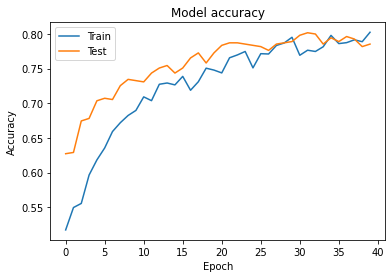

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

# Train model for a given number of epochs
history = model.fit(x_train, y_train, batch_size=128, epochs=40, verbose=1, validation_data=(x_test, y_test))

# Evaluate model against test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Prediction**

In [12]:
predictions = model.predict(padded_sequences)
most_likely = predictions.argmax(1)

**Error Analysis**

We have gotten a lot of compliments on it.
Prediction: 0, label: 1


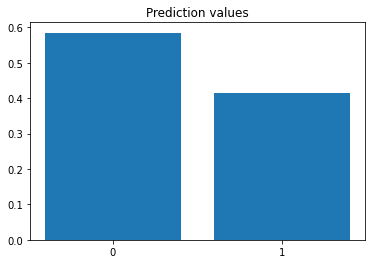

In [13]:
for i in range(10000):
    index = random.randrange(len(predictions))
    if most_likely[index] != sentiments[index]:
        break

print(comments[index])
print('Prediction: %d, label: %d' % (most_likely[index], sentiments[index]))

plt.bar(range(num_classes), predictions[index], tick_label=range(num_classes))
plt.title('Prediction values')
plt.show()